# benchmarking different ordered set variants
We want an ordered set to use for axis indices, akin to Pandas.Index. We do not intend to support insertion or deletion of elements, but allowing for replacement of elements makes sense. To save memory, we would prefer a high load factor. The [Robin Hood hash table (Celis 1986)](https://cs.uwaterloo.ca/research/tr/1986/CS-86-14.pdf) is supposed to perform well at high load factors, so we use it. The original paper described a tombstone deletion scheme and a so-called smart search lookup designed to minimize the number of probes. However, this smart search accesses elements out of order and is thus not very cache-friendly. Moreover, [newer sources](https://codecapsule.com/2013/11/17/robin-hood-hashing-backward-shift-deletion/) seem to indicate that linear search and backshift deletion perform better under workloads with many deletion-insertion operations.

Our goal here is to benchmark different implementations of an ordered set. All implementations are based on the Robin Hood hash table, but differ in the following:
- `Index` implements double hashing, smart search, and tombstone deletion
- `Index2` implements linear probing, smart search, and tombstone deletion
- `Index3` implements linear probing, smart search, and backshift deletion
- `Index4` implements linear probing, linear search, and backshift deletion

In [1]:
using Random
using Statistics
using Test
using BenchmarkTools
using Gadfly
import Cairo, Fontconfig
using CategoricalArrays
using DataFrames
using CSV
using ProgressMeter
include("index.jl")
include("index2.jl")
include("index3.jl")
include("index4.jl")

## unit tests
we first test the implementations for basic functionality

In [2]:
Random.seed!(42)
size = rand(100:200)

types_totest = (Index, Index2, Index3, Index4)

function make_testvalues(size::Integer)
    testvalues = Vector{String}(undef, size)
    for i in 1:size
        length = rand(1:200)
        testvalues[i] = randstring(length)
    end
    return testvalues
end

testvalues = make_testvalues(size)
testvalues2 = make_testvalues(size)

@testset "type $(string(t))" for t in types_totest
    idx = t(testvalues)
    @testset "integer indexing" begin
        @testset "element: $i" for (i, v) in enumerate(testvalues)
            @test idx[i] == v
        end
    end

    @testset "value indexing" begin
        @testset "element: $i" for (i, v) in enumerate(testvalues)
            @test idx[v] == i
        end
    end


    testvalues3 = copy(testvalues)
    @testset "value replacement" begin
        @testset "element: $i" for (i, v) in enumerate(testvalues)
            testvalues3[i] = testvalues2[i]
            idx[v] = testvalues2[i]
            @test idx == testvalues3
        end
    end

    @testset "index replacement" begin
        @testset "element $i" for (i, v) in enumerate(testvalues2)
            testvalues3[i] = testvalues[i]
            idx[i] = testvalues[i]
            @test idx == testvalues3
        end
    end
end;

Test Summary: | Pass  Total
type Index    |  520    520
Test Summary: | Pass  Total
type Index2   |  520    520
Test Summary: | Pass  Total
type Index3   |  520    520
Test Summary: | Pass  Total
type Index4   |  520    520


## benchmarks
The rough benchmarking scheme is taken from [Emmanuel Gossaert](https://codecapsule.com/2013/11/11/robin-hood-hashing/). We first construct an ordered set with 100000 strings. We then replace 10000 elements with random newly generated strings. This procedure is repeated 50 times, after each iteration we measure different statistics regarding probe length, time required to perform the replacement operation, and also time to simply access elements without replacing them.

In [3]:
Random.seed!(42)
size = 100000

function ripple(idx, range::AbstractUnitRange)
    for i in range
        length = rand(200:500)
        idx[i] = randstring(length)
    end
end

function access(idx, range::AbstractUnitRange)
    out = Vector{String}(undef, length(range))
    for (j, i) in enumerate(range) out[j] = idx[i] # do someting to prevent the compiler from optimizing away the code
    end
    return out
end

# compile the functions
for t in types_totest
    idx = t(string.(collect(1:size)))
    ripple(idx, 1:2)
    access(idx, 1:2)
end

testvalues = make_testvalues(size)
probing = Dict(Index => "double hashing", Index2 => "linear", Index3 => "linear", Index4 => "linear")
deletion = Dict(Index => "tombstone", Index2 => "tombstone", Index3 => "backshift", Index4 => "backshift")
search = Dict(Index => "smart", Index2 => "smart", Index3 => "smart", Index4 => "linear")
results = DataFrame(
    iter=UInt[],
    mean_pbl=Float64[],
    var_pbl=Float64[],
    median_pbl=Float64[],
    max_pbl=UInt[],
    time=Float64[],
    bytes_alloc=UInt[],
    malloc_realloc_calls=UInt[],
    time_access=Float64[],
    type=CategoricalVector(undef, 0),
    probing=CategoricalVector(undef, 0),
    deletion=CategoricalVector(undef, 0),
    search=CategoricalVector(undef, 0)
);

In [4]:
nripple = Int(round(0.1 * size))
niters = 50
pbar = Progress(length(types_totest) * niters)
for t in types_totest
    Random.seed!(42)
    idx = t(testvalues)
    for (i, start) in enumerate(Int.(round.(range(1, size - nripple + 1, length=niters))))
        next!(pbar; showvalues=((:index, string(t)), (:start, start)))
        stats = @timed ripple(idx, start:(start + nripple - 1))
        stats_access = @benchmark access($idx, $start:($start + $nripple - 1)) seconds=0.5
                
        probepositions = filter(x -> x > 0x0, idx.probepositions)
        push!(
            results,
            Dict(
                :iter => i,
                :mean_pbl => mean(probepositions),
                :var_pbl => var(probepositions),
                :median_pbl => median(probepositions),
                :max_pbl => maximum(probepositions),
                :time => stats.time,
                :bytes_alloc => stats.gcstats.allocd,
                :malloc_realloc_calls => stats.gcstats.malloc + stats.gcstats.realloc,
                :time_access => mean(stats_access.times) / 1e9,
                :type => string(t),
                :probing => probing[t],
                :deletion => deletion[t],
                :search => search[t],
            ),
        )
    end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/ilia/.julia/packages/ProgressMeter/0ub8y/src/ProgressMeter.jl:474
Progress: 100%|█████████████████████████████████████████| Time: 0:06:22
  index:  Index4
  start:  90001


## benchmarking results

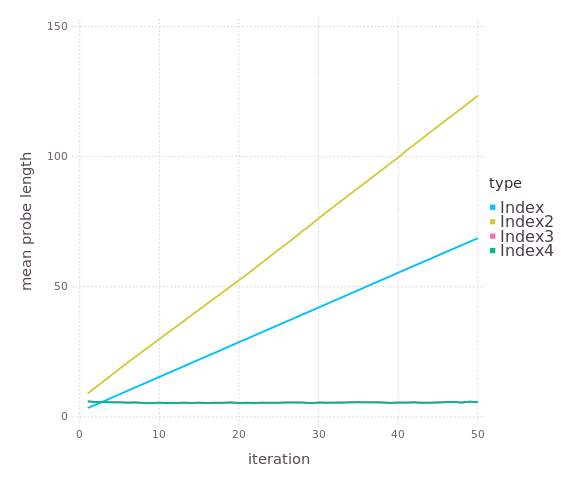

false

In [5]:
plot(results, x=:iter, y=:mean_pbl, color=:type, group=:type, Guide.xlabel("iteration"), Guide.ylabel("mean probe length"), Geom.line, Theme(key_label_font_size=12pt, line_width=0.5mm)) |> PNG(15cm, 13cm)

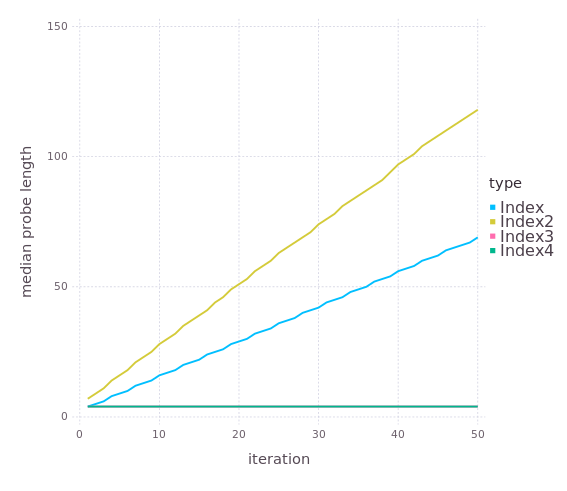

false

In [6]:
plot(results, x=:iter, y=:median_pbl, color=:type, group=:type, Guide.xlabel("iteration"), Guide.ylabel("median probe length"), Geom.line, Theme(key_label_font_size=12pt, line_width=0.5mm)) |> PNG(15cm, 13cm)

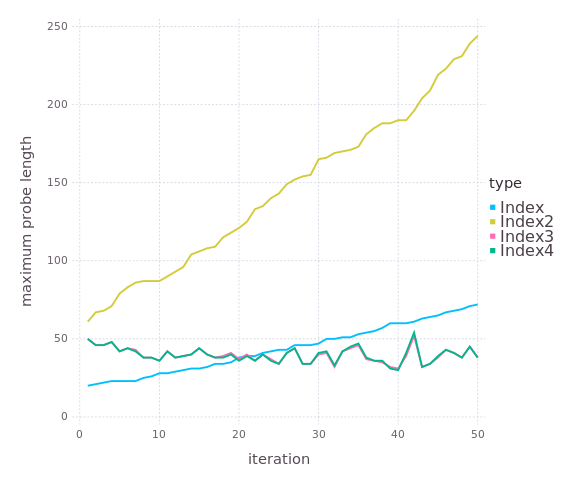

false

In [7]:
plot(results, x=:iter, y=:max_pbl, color=:type, group=:type, Guide.xlabel("iteration"), Guide.ylabel("maximum probe length"), Geom.line, Theme(key_label_font_size=12pt, line_width=0.5mm)) |> PNG(15cm, 13cm)

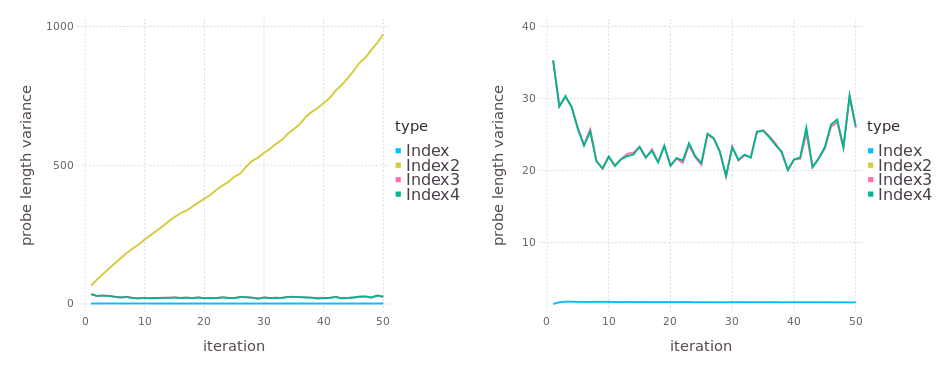

false

In [8]:
hstack(
    plot(results, x=:iter, y=:var_pbl, color=:type, group=:type, Guide.xlabel("iteration"), Guide.ylabel("probe length variance"), Geom.line, Theme(key_label_font_size=12pt, line_width=0.5mm)),
    plot(results, x=:iter, y=:var_pbl, color=:type, group=:type, Guide.xlabel("iteration"), Guide.ylabel("probe length variance"), Geom.line, Theme(key_label_font_size=12pt, line_width=0.5mm), Coord.cartesian(ymax=40))
) |> PNG(25cm, 10cm)

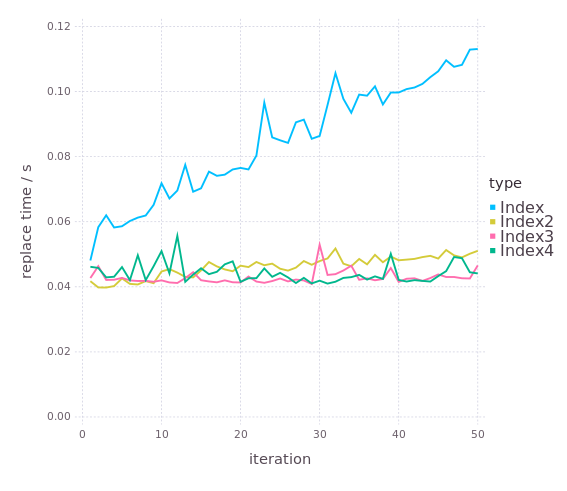

false

In [9]:
plot(results, x=:iter, y=:time, color=:type, group=:type, Guide.xlabel("iteration"), Guide.ylabel("replace time / s"), Geom.line, Theme(key_label_font_size=12pt, line_width=0.5mm)) |> PNG(15cm, 13cm)

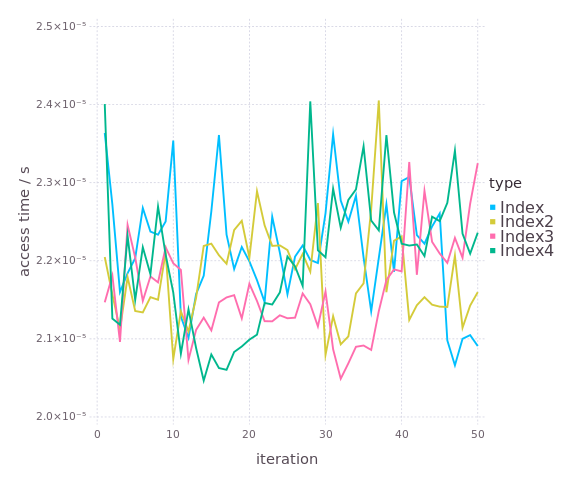

false

In [10]:
plot(results, x=:iter, y=:time_access, color=:type, group=:type, Guide.xlabel("iteration"), Guide.ylabel("access time / s"), Geom.line, Theme(key_label_font_size=12pt, line_width=0.5mm)) |> PNG(15cm, 13cm)

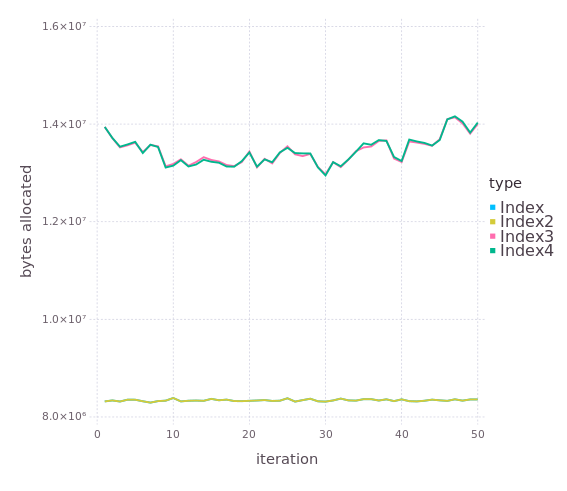

false

In [11]:
plot(results, x=:iter, y=:bytes_alloc, color=:type, group=:type, Guide.xlabel("iteration"), Guide.ylabel("bytes allocated"), Geom.line, Theme(key_label_font_size=12pt, line_width=0.5mm)) |> PNG(15cm, 13cm)

In [12]:
CSV.write("results.csv", results)

"results.csv"

## conclusion
`Index` and `Index2` demonstrate increasing probe lengths and replacement times over the course of the benchmark. On the other hand, `Index3` and `Index4` show constant probe lengths. They have somewhat higher probe length variance than `Index`, but this doesn't seem to affect replacement or access times. `Index3` and `Index4` allocate about twice as much memory during the replacement operation as `Index` and `Index2`, but this is due to the view objects in the deletion function and constitutes only approx. 150 bytes per deletion, so it's negligible. Altogether, linear probing with backward shift deletion performs best in our benchmark.

Since there seems to be no major difference in access time between `Index3` (smart search) and `Index4` (linear search), we will use the latter for Muon due to its simpler implementation.

In [13]:
versioninfo()

Julia Version 1.5.3
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-3770K CPU @ 3.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, ivybridge)
